# Purpose:
#### To test changes to the app before incorporating

In [1]:
import json
import math
from random import Random
import random
from pathlib import Path
import numpy as np
import pandas as pd

#from vou.person import BehaviorWhenResumingUse, OverdoseType, Person
from vou.utils import logistic

from collections import deque
from enum import IntEnum, unique
from itertools import repeat

import numpy as np
from vou.visualize import visualize


In [2]:
def load_json(json_file: Path):
    """
    Loads a JSON file to a JSON object
    """
    with open(json_file) as f:
        return json.load(f)

In [3]:
def weighted_random_by_dct(dct, rng:random.Random):
    rand_val = rng.random()
    total = 0
    for k, v in dct.items():
        total += v 
        if rand_val <= total:
            return k 
    return max(dct.items())[0]

    

In [4]:
drug_params = load_json("vou/drug_params.json")
drug_params['source_probability']


{'initial_doctor_increase': 0.3, 'secondary_doctor': 0.5, 'dealer': 0.8}

## Create Person Class (and all enum, etc. found in the person.py script)
* Copy/paste here for testing

In [11]:

@unique
class BehaviorWhenResumingUse(IntEnum):
    SAME_DOSE = 0
    LOWER_DOSE = 1


@unique
class OverdoseType(IntEnum):
    NON_FATAL = 0
    FATAL = 1


@unique
class DoseIncreaseSource(IntEnum):
    PRIMARY_DOCTOR = 0
    SECONDARY_DOCTOR = 1
    DEALER = 2
    WILL_NOT_INCREASE = 3
    FIRST_ATTEMPT = 4


class Person:
    def __init__(
        self,
        rng: Random,
        starting_dose: int = 50,
        dose_increase: int = 25,
        base_threshold: float = 0.001,
        tolerance_window: int = 3_000,
        external_risk: float = 0.5,
        internal_risk: float = 0.5,
        behavioral_variability: float = 0.1,
        behavior_when_resuming_use: BehaviorWhenResumingUse = None,
    ):
        # Parameters
        self.rng = rng
        self.starting_dose = starting_dose
        self.dose = starting_dose
        self.dose_increase = dose_increase
        self.threshold = base_threshold
        self.tolerance_window = tolerance_window
        self.external_risk = external_risk
        self.internal_risk = internal_risk
        self.behavioral_variability = behavioral_variability
        self.update_downward_pressure()
        self.set_risk_logit()
        self.behavior_when_resuming_use = behavior_when_resuming_use
        self.post_OD_use_pause = None
        self.last_dose_increase = 0

        self.drug_params = load_json("vou/drug_params.json")

        # A bunch of empty lists to store data during simulation
        self.concentration = []
        self.tolerance_input = deque(repeat(0, self.tolerance_window))
        self.tolerance_input_sum = 0
        self.desperation = []
        self.habit = []
        self.effect = []
        self.overdoses = []
        self.effect_record = {}
        self.dose_peaks = []
        self.dose_increase_record = {}
        self.dose_sources = []

    def update_downward_pressure(
        self, midpoint_min: int = 100, midpoint_max: int = 1_000
    ):
        """
        Sets the person's downward pressure. Downward pressure is intended to represent
        the person's overall motivation NOT to use and increase dose. It counterbalances
        their motivation TO use from their threshold and desperation and their motivation
        TO increase dose from their effect and increase threshold.

        Downward pressure is computed with a logistic function taking the following
        arguments:

        - Person's external risk: used as the intercept, or "baseline" downward pressure
        - Person's internal risk: transformed and used as the midpoint of the logistic
          curve
        - Person's current dose: used as the X value
        """
        # Person's internal risk is a value from 0 to 1. We use this in its raw
        # form, but also need to convert it to the sigmoid midpoint parameter for the
        # downward pressure logistic function. This function takes an internal risk from
        # 0 to 1 and scales it to a midpoint in the specified range.
        midpoint_range = midpoint_max - midpoint_min
        midpoint = (self.internal_risk * midpoint_range) + midpoint_min

        # External risk is quantified as 0=good, 1=bad for intuitiveness. However,
        # in the logistic function for downward pressure, 0 is bad and 1 is good,
        # since higher values lead to more downward pressure. Therefore, we invert
        # external risk to get the user's downward pressure baseline.
        baseline_dp = 1 - self.external_risk

        # Main logistic function
        self.downward_pressure = baseline_dp + (
            (1 - baseline_dp) / (1 + np.exp(-0.005 * (self.dose - midpoint)))
        )

    def set_risk_logit(self):
        """
        The risk logit is used to adjust the person's threshold for opioid use. Persons 
        with extreme risk levels (low or high) will have extreme threshold multipliers,
        while persons with normal risk levels will have threshold multipliers close to zero. 
        """
        avg_risk = (self.external_risk + self.internal_risk) / 2
        self.risk_logit = np.log(avg_risk / (1 - avg_risk)) / 0.25

    def lower_dose_after_pause(self):
        """
        Sets the person's dose to their maximum past habit, rounded to the nearest
        increment of their dose increase amount.
        Also updates their downward pressure since dose has changed.
        """
        self.dose = self.dose_increase * round(max(self.habit) / self.dose_increase)
        self.update_downward_pressure()

    def will_take_dose(self, t: int):
        """
        Evaluates several conditions to decide whether the person will take another
        dose at a given time point.

        Returns a boolean value indicating whether the person will take a dose.
        """
        # Is a recent overdose preventing the person from using?
        if self.overdoses and t < self.overdoses[-1] + self.post_OD_use_pause:
            return False
        # Does the person want another dose?
        elif self.concentration[-1] > self.threshold:
            return False
        # Does downward pressure prevent person from taking dose when they want one?
        elif self.rng.random() < self.downward_pressure:
            return False
        else:
            return True

    def did_overdose(self, x0: float = 1243.6936832876, k: float = 0.0143710866):
        """
        Checks whether the person's most recent opioid dose causes an overdose.

        First, a baseline OD risk value is generated using a function derived from
        Dasgupta et al 2016. A logistic model was fitted to their data, along with 
        the assumption that a dose of 2 grams has an OD probability of 1. (See
        notebooks/od_risk_curve.ipynb). We use that model to generate the baseline
        risk value for the person's dose.

        Since the Dasgupta study used prescription data, we assume that these overdose
        risks are for people who are tolerant to their prescribed dose. Therefore,
        we add an additional risk multiplier based on the ratio of the dose to the
        person's tolerance.

        A very general heuristic is that at steady state, (preferred_dose / tolerance)
        roughly equals 2. We define "excess" as (dose / tolerance) - 1, or roughly 1 at
        steady state. We multiply the person's baseline OD risk by this excess squared.
        """
        # Use the second-to-last values of concentration and habit, since this method
        # is designed to be invoked when a dose peak has been detected. The peak finding
        # logic detects peaks at the time step *after* the peak occurred, so the peak
        # values are one item back in these lists.
        dose = self.concentration[-2]
        tolerance = self.habit[-2]

        # bound extremely low tolerance values to avoid huge excess values
        tolerance = max(1, tolerance)

        # parameters based on Dasgupta et al 2016 - see notebooks/od_risk_curve.ipynb
        baseline_OD_risk = logistic(x=dose, L=1, k=k, x0=x0)

        excess = ((dose / tolerance) - 1) ** 2

        tolerance_adjusted_OD_risk = baseline_OD_risk * excess

        if self.rng.random() < tolerance_adjusted_OD_risk:
            # Overdose occurred
            return True

    def overdose(self, t: int):
        """
        Takes the necessary actions when the person has overdosed. Records the OD,
        sets the amount of time the person will stop using after OD, and adjusts
        their dose if they will reduce their dose after OD.

        Returns the type of overdose, fatal or non-fatal. Simulation.simulate() uses
        this value to break the simulation loop in the case of a fatal OD.
        """
        self.overdoses.append(t)
        # Set amount of time person will stop using after OD.
        self.post_OD_use_pause = self.compute_OD_use_pause()
        # Adjust person's dose.
        self.dose = self.dose * self.compute_OD_dose_reduction()
        # Check if overdose caused death. Per Dunn et al 2010, about 1 in every 8.5
        # ODs is fatal.
        if self.rng.random() < (1 / 8.5):
            return OverdoseType.FATAL
        else:
            return OverdoseType.NON_FATAL

    def compute_OD_use_pause(self):
        """
        Computes the amount of time the person will pause use after an overdose based
        on the person's risk factors and a random draw. The lowest risk persons will
        pause 60 days. This value decays exponentially quite quickly, since research
        shows that most persons resume use within 24 hours of an OD.
        """
        maximum = 60 * 100
        rate = -0.999
        rand = self.rng.uniform(0.5, 1.5)
        combined_risk = self.internal_risk + self.external_risk
        pause = (maximum * (1 + rate) ** combined_risk) * rand
        return pause

    def compute_OD_dose_reduction(self):
        """
        Computes a multiplier by which the person will reduce their dose after an OD
        based on the person's risk factors and a random draw. The lowest risk persons
        will reduce their dose by half, while the highest risk persons will maintain
        the same dose.
        """
        intercept = 0.5
        slope = 0.25
        rand = self.rng.uniform(0.5, 1.5)
        combined_risk = self.internal_risk + self.external_risk
        dose_reduction = (combined_risk * slope + intercept) * rand
        if dose_reduction > 1:
            return 1
        else:
            return dose_reduction

    def will_increase_dose(
        self, effect_window: int = 20, increase_threshold: float = 0.4,
    ):
        """
        Checks whether the person will increase their dose. Based on a comparison of
        the average of past dose effects to the person's desired dose. Effect window
        and increase threshold are calibrated parameters and not intended to be varied
        during simulation.

        Logic for the source of the increased dose is added here.  If a person will increase
        their dose for the first time, they will attempt through their primary doctor.  If
        this is their second time, they will have a 50% chance of trying through a secondary
        doctor or a dealer.
        """
        self.source_probability_primary = self.drug_params["source_probability"][
            "initial_doctor_increase"
        ]
        self.source_probability_secondary = self.drug_params["source_probability"][
            "secondary_doctor"
        ]
        self.source_probability_dealer = self.drug_params["source_probability"][
            "dealer"
        ]
        self.secondary_doc_dealer_prob = self.drug_params["secondary_doc_dealer_prob"]

        if len(list(self.dose_increase_record.values())) == 0:
            last_attempt_src = DoseIncreaseSource.PRIMARY_DOCTOR
            last_attempt_success = None

        else:
            last_attempt_src = list(self.dose_increase_record.values())[-1]["source"]
            last_attempt_success = list(self.dose_increase_record.values())[-1][
                "success"
            ]

        last_n_dose_effects = [
            self.effect_record[d]
            for d in self.dose_peaks[-effect_window:]
            if d > self.last_dose_increase
        ]

        # Check if individual will increase dose
        if self.dose >= 2_000:

            will_increase_dose = False
            increase_dose_src = DoseIncreaseSource.WILL_NOT_INCREASE

        elif len(last_n_dose_effects) == 0:

            will_increase_dose = False
            increase_dose_src = DoseIncreaseSource.WILL_NOT_INCREASE

        elif np.mean(last_n_dose_effects) >= (self.dose * increase_threshold):

            will_increase_dose = False
            increase_dose_src = DoseIncreaseSource.WILL_NOT_INCREASE

        elif self.rng.random() <= self.downward_pressure:

            will_increase_dose = False
            increase_dose_src = DoseIncreaseSource.WILL_NOT_INCREASE
        else:
            will_increase_dose = True

        # Determine source of dose increase
        if will_increase_dose == True:

            # if first time trying to increase dose, go to primary doctor for potential increase
            ## Also, if the last attempt to increase from primary was successful, try again with primary
            if (len(self.dose_increase_record) == 0) | (
                (last_attempt_src == DoseIncreaseSource.PRIMARY_DOCTOR)
                & (last_attempt_success == True)
            ):

                # probability of primary doctor increasing
                if self.rng.random() <= self.source_probability_primary:
                    will_increase_dose = True
                    increase_dose_src = DoseIncreaseSource.PRIMARY_DOCTOR

                else:
                    will_increase_dose = False
                    increase_dose_src = DoseIncreaseSource.PRIMARY_DOCTOR

            # if the last time they tried to increase, they tried from their primary and failed, try from either dealer or secondary doctor

            ##### If your last increase attempt was successful, but it was a secondary doctor, you'll enter this situation again
            elif (last_attempt_success == False) | (
                last_attempt_src == DoseIncreaseSource.SECONDARY_DOCTOR
            ):

                if self.rng.random() <= self.secondary_doc_dealer_prob:

                    if self.rng.random() <= self.source_probability_secondary:
                        will_increase_dose = True
                        increase_dose_src = DoseIncreaseSource.SECONDARY_DOCTOR

                    else:
                        will_increase_dose = False
                        increase_dose_src = DoseIncreaseSource.SECONDARY_DOCTOR

                else:

                    if self.rng.random() <= self.source_probability_dealer:
                        will_increase_dose = True
                        increase_dose_src = DoseIncreaseSource.DEALER

                    else:
                        will_increase_dose = True
                        increase_dose_src = DoseIncreaseSource.DEALER

            else:  # only other option is you successfuly found a dealer, in which case you can always increase

                will_increase_dose = True
                increase_dose_src = DoseIncreaseSource.DEALER

        # If first timestep then source is primary doctor
        if len(self.dose_increase_record) == 0:  # if it's first timestep
            increase_dose_src = DoseIncreaseSource.PRIMARY_DOCTOR

        # if not first timestep then source is the last source that doesn't equal WILL_NOT_INCREASE
        elif increase_dose_src == DoseIncreaseSource.WILL_NOT_INCREASE:
            increase_dose_src = [
                x
                for x in list(self.dose_increase_record.values())
                if x["source"] != DoseIncreaseSource.WILL_NOT_INCREASE
            ][-1]["source"]

        # Dose type based on dose source
        increase_dose_type = weighted_random_by_dct(
            self.drug_params["drugs_by_source"][str(increase_dose_src)], self.rng
        )

        return {
            "source": increase_dose_src,
            "success": will_increase_dose,
            "dose_type": increase_dose_type,
        }

    def increase_dose(self, t: int):
        """
        Takes the necessary steps when the person increases their dose. Updates dose,
        records the current time as the last time of dose increase, and updates the
        person's downward pressure for the new dose.
        """
        self.dose += self.dose_increase
        self.last_dose_increase = t
        self.update_downward_pressure()



## Create Simulation class (copy/paste from simulation.py for testing)

In [21]:

class Simulation:
    def __init__(
        self,
        person: Person,
        rng: Random,
        days: int = 730,
        stop_use_day: int = None,
        resume_use_day: int = None,
        dose_variability: float = 0.1,
        availability: float = 0.9,
        fentanyl_prob: float = 0.0001,
        counterfeit_prob: float = 0.1,
    ):
        # Parameters
        self.person = person
        self.rng = rng
        self.days = days
        self.stop_use_time = None if stop_use_day is None else stop_use_day * 100
        self.resume_use_time = None if resume_use_day is None else resume_use_day * 100
        self.dose_variability = dose_variability
        self.availability = availability
        self.fentanyl_prob = fentanyl_prob
        self.counterfeit_prob = counterfeit_prob

        # Variables used in simulation
        self.time_since_dose = 0
        self.last_amount_taken = 0
        self.conc_when_dose_taken = 0
        self.dose_peak_pending = False
        self.opioid_available = True
        self.integralA = [0]
        self.integralB = [0]
        self.integralC = [0]
        self.integralD = [0]
        self.dose_method = "Pill"
        self.compliant = True

    def simulate(self):
        """
        The main function to conduct a simulation. Simulates the opioid use behavior of a
        single person. The simulation loops through time points (100 time points per day,
        ~15 minutes each) for the number of days specified at instantiation. Conducts
        several steps at each time point to simulate the person's opioid use behavior.
        Records the key measures (opioid concentration, habit, effect, desperation, and
        overdoses) over time.
        """
        for t in range(self.days * 100):

            # Reset dose taken indicator for next iteration
            dose_taken_at_t = False

            # Add to time since last dose
            self.time_since_dose += 1

            # Compute the person's concentration of opioid using pharmacokinetic model
            conc = self.compute_concentration()
            self.person.concentration.append(conc)

            # Add concentration to tolerance input
            self.person.tolerance_input_sum -= self.person.tolerance_input.popleft()
            self.person.tolerance_input_sum += conc
            self.person.tolerance_input.append(conc)

            # Update opioid availability
            self.update_availability(t)

            # Check if the person will take another dose
            if self.opioid_available is True:
                # if self.person.will_take_dose(t) is True:
                if self.person.will_take_dose(t) is True or t % 100 == 0:
                    self.record_dose_taken(t)
                    dose_taken_at_t = True

            # Compute the person's opioid use habit at t
            self.person.habit.append(self.compute_habit(t))

            # Compute the opioid's effect on the person (concentration - habit)
            self.person.effect.append(self.compute_effect())

            # If peak concentration for the last dose taken has not been reached
            # yet, check if it was reached at this time step
            if (
                self.dose_peak_pending is True
                and dose_taken_at_t is False
                and len(self.person.concentration) > 1
            ):
                # If concentration at t is lower than at t-1, then t-1 was the dose's peak.
                # Take all the actions necessary to record the dose peak.
                if self.person.concentration[-1] < self.person.concentration[-2]:
                    # Reset indicator
                    self.dose_peak_pending = False
                    # Check for overdose.
                    if self.person.did_overdose() is True:
                        overdose = self.person.overdose(t)
                        if overdose == OverdoseType.FATAL:
                            break
                    # Store effect in a dict of effects at time of each dose's peak
                    # (to be used in determining when the person increases their dose.)
                    self.person.effect_record[t - 1] = self.person.effect[-2]
                    self.person.dose_peaks.append(t - 1)
                    # Check if the person will increase their dose.
                    dose_increase = self.person.will_increase_dose()
                    if dose_increase["success"]:
                        self.person.increase_dose(t)
                    self.person.dose_increase_record[t] = dose_increase

            # Compute the person's threshold and desperation
            # First, compute integrals of concentration to be used in calculating
            # threshold and desperation
            self.compute_concentration_integrals()
            # Next, compute the person's desperation at t
            self.person.desperation.append(self.compute_desperation())
            # Finally, update the person's threshold for the next iteration
            self.person.threshold = self.compute_threshold()

             # Add the person's dose_source to the list
            self.person.dose_sources.append(self.dose_source)

            

    def compute_concentration(self, ke: float = 0.0594):
        """
        Computes the person's concentration of opioids in MME at a time step.

        The coefficient of elimination (Ke) was calibrated to the half life of morphine.
        Per Lotsch 2005, 3 studies identifed this value as 2.8 hours, which we use here.

        This model uses 100 time steps per day, so each time step equates to
        24 * 60 / 100 = 14.4 minutes. The half life in model time units is 
        2.8 * 60 / 14.4 = 11.667 time units.

        For first-order decay functions, the decay constant Ke = ln(2) / half_life.
        Therefore, in our case:

        Ke = ln(2) / 11.667 = 0.0594

        The coefficient of absorption (Ka) can be varied to simulate different modes
        of opioid administration. The default value is high enough that the entire dose
        is absorbed by the following time step, simulating an injection (or any mode of
        administration where the entire dose is absorbed within ~15 minutes). Reducing
        Ka can simulate orally consuming pills, where it takes several time steps for the
        dose to be absorbed. See `notebooks/pk_absorb_eliminate.ipynb` for details.
        """
        if self.dose_method == "Pill":
            ka = 0.4
        else:
            ka = 10

        starting_amount = self.conc_when_dose_taken + self.last_amount_taken
        t = self.time_since_dose

        return ((starting_amount * ka) / (ka - ke)) * (
            (math.exp(-ke * t)) - (math.exp(-ka * t))
        )

    def compute_effect(self, ke: float = 0.0594):
        """
        Computes opioid's effect on the the person at a time step, given their
        concentration of opioid and opioid use habit.
        
        Ke is a calibrated parameter and Ka can be adjusted to simulate different modes of
        administration. See docstring for compute_concentration for details.
        """
        if self.dose_method == "Pill":
            ka = 0.4
        else:
            ka = 10

        starting_amount = (
            self.conc_when_dose_taken + self.last_amount_taken - self.person.habit[-1]
        )
        t = self.time_since_dose

        effect = ((starting_amount * ka) / (ka - ke)) * (
            (math.exp(-ke * t)) - (math.exp(-ka * t))
        )

        return max(effect, 0)

    def update_availability(self, t: int):
        """
        Updates the variable indicating whether opioids are available to the user.

        Includes two steps:

        1. Update availability once per day (100 time units) Based on a random draw,
        adjusted by person's desperation, relative to the parameter indicating how often
        opioids are available on any given day.

        2. Check if t is in the stop use period. If so, the drug is always unavailable.
        Further, if t is the time of resuming use after stop, check whether the person
        will reduce their dose.
        """
        # Step 1
        if t % 100 == 0:
            rand = self.rng.random()
            # Adjust availability by desperation - more desperate user seeks drug
            # more aggressively.
            if self.person.desperation:
                if self.person.desperation[-2] > 1:
                    rand = rand / self.person.desperation[-2]
            if rand < self.availability:
                self.opioid_available = True
            else:
                self.opioid_available = False
        # Step 2
        if self.stop_use_time:
            if self.resume_use_time:
                if t >= self.stop_use_time and t < self.resume_use_time:
                    self.opioid_available = False
                elif t == self.resume_use_time:
                    if (
                        self.person.behavior_when_resuming_use
                        == BehaviorWhenResumingUse.LOWER_DOSE
                    ):
                        self.person.lower_dose_after_pause()
            elif t >= self.stop_use_time:
                self.opioid_available = False

    def record_dose_taken(self, t):
        """
        Takes the necessary actions when the person has taken a dose.

        Increase record is used to update the dose source, type, and method
        * If this is the first timestep, go with Primary and a random drug from that distribution
        * If not, go with the last specified dose type and source --specified from will_increase_dose
            * This will cause the type of dose to change each time increase is True
        * Method of use will change each time a dose is taken based on the probabilities associated
            with drug type
        """

        # create dataframe of dose increases to determine last source
        ## Currently using option 1 - last source is the continued source
        if len(self.person.dose_increase_record) > 0:

            ### Filter to the last entry where the source was not "WILL NOT INCREASE" and the attempt to increase was a success
            ##### If that does not exist then the source/etc. will be based on primary
            successful_dose_increases = [
                x
                for x in list(self.person.dose_increase_record.values())
                if (x["source"] != DoseIncreaseSource.WILL_NOT_INCREASE)
                & (x["success"] == True)
            ]

            # Determine source
            if len(successful_dose_increases) == 0:  # if first record --primary
                self.dose_source = DoseIncreaseSource.PRIMARY_DOCTOR
                self.dose_type = weighted_random_by_dct(
                    self.person.drug_params["drugs_by_source"][str(self.dose_source)],
                    self.rng,
                )

            else:
                self.dose_source = successful_dose_increases[-1]["source"]
                self.dose_type = successful_dose_increases[-1]["dose_type"]

        else:  # if it's the first timestamp go to primary
            self.dose_source = DoseIncreaseSource.PRIMARY_DOCTOR
            self.dose_type = weighted_random_by_dct(
                self.person.drug_params["drugs_by_source"][str(self.dose_source)],
                self.rng,
            )

        # Determine the method of use based on the drug
        self.dose_method = weighted_random_by_dct(
            self.person.drug_params["admin_mode_distributions"][self.dose_type],
            self.rng,
        )

        # check if the person is compliant (non-compliant if source != PRIMARY_DOCTOR)
        if self.dose_source == DoseIncreaseSource.PRIMARY_DOCTOR:
            self.compliant = True 

        elif self.dose_source != DoseIncreaseSource.PRIMARY_DOCTOR:
            self.compliant = False
            print("changed compliance")
        # Update the dose peak pending indicator, which will cue all time steps in the
        # future to check if peak concentration was reached. When peak concentration is
        # reached, this will be set back to false.
        self.dose_peak_pending = True
        # Update the variable storing the person's concentration when the dose was
        # taken to be used for later concentration calculations.
        self.conc_when_dose_taken = self.person.concentration[-1]
        # Reset the time since dose indicator to zero for concentration calculations.
        self.time_since_dose = 0
        # Update the variable storing the last amount taken for concentration calcs.
        self.last_amount_taken = self.compute_amount_taken()
        # Recalculate the person's concentration for this time step
        new_conc = self.compute_concentration()
        self.person.concentration[-1] = new_conc
        # Add the new concentration to the person's tolerance window
        self.person.tolerance_input_sum -= self.person.tolerance_input.pop()
        self.person.tolerance_input_sum += new_conc
        self.person.tolerance_input.append(new_conc)

    def compute_amount_taken(self):
        """
        Computes the amount of opioid taken in MME when the person takes a dose.

        First, checks whether the user decides to vary their dose. 
        
        Next, check whether the dose consists of counterfeit pills. If not, the dose
        taken is the user's preferred dose exactly. If so, the dose taken is modified
        by several multipliers.

        1. The person's behavioral variability parameter represents variation in the dose
        the person intends to take relative to their usual preferred dose.
        
        2. The dose variability parameter represents general variation in the purity
        and consistency of counterfeit pills.

        3. The fentanyl probabiltiy parameter represents the likelihood that a
        counterfeit pill is part of a "bad batch" contaminated with fentanyl. 
        If so, the modified dose is multiplied by a random value:
        1 + a random draw from an exponential distribution with mean 0.25 (the 
        lambd parameter in random.expovariate is 1 divided by the mean).
        """
        modified_dose = self.person.dose * self.rng.uniform(
            1 - self.person.behavioral_variability,
            1 + self.person.behavioral_variability,
        )

        if self.rng.random() < self.counterfeit_prob:

            modified_dose = modified_dose * self.rng.uniform(
                1 - self.dose_variability, 1 + self.dose_variability
            )
            if self.rng.random() < self.fentanyl_prob:
                modified_dose = modified_dose * (1 + self.rng.expovariate(1 / 0.25))

        return modified_dose

    def compute_habit(
        self,
        t: int,
        conc_multiplier: int = 1.85,
        L1: float = 1.0275,
        L2: float = 0.58,
        K1: float = 0.2,
        K2: float = 0.0002,
        X1: float = 0.175,
    ):
        """
        Computes the person's opioid use "habit" at a time point.

        We conceptualize habit as a function of the person's recent use behavior. When
        a person has been using more, their habit will be higher.

        Parameters were calibrated and are not intended to be varied during simulation.
        They are defined in the comments below.
        """
        # Go ahead and return zero if this is the first time point.
        if t == 0:
            return 0
        # Compute the rolling mean of the person's opioid concentration using their
        # tolerance window.
        #
        # conc_multiplier is a calibrated parameter used to increase the concentration
        # prior to the logistic effect function. Without this increase, effect is too
        # small relative to concentration.
        rolling_concentration = (
            self.person.tolerance_input_sum / self.person.tolerance_window
        ) * conc_multiplier

        # Compute habit based on a logistic function of the rolling concentration.
        #
        # All of the logistic function parameters are adjusted by dose. This results in
        # the relationship between concentration and effect changing at different doses.
        # This results in the behavior where people tend to maintain use of a low dose
        # for a long time, and increase their dose faster as the dose gets higher.
        #
        # L1 and L2 are calibrated parameters used to vary the logistic curve's maximum
        # value exponentially by dose. This makes habit get higher relative to dose as
        # dose increases.
        #
        # K1 and K2 are calibrated parameters used to vary the logistic growth rate
        # linearly by dose. This makes habit grow more slowly as dose increases, moderating
        # the effect of L1 and L2.
        #
        # X1 is a calibrated parameter used to vary the rolling concentration value at the
        # logistic curve's midpoint by dose. This allows us to obtain a similarly-shaped
        # curve at a wide range of doses.
        return logistic(
            x=rolling_concentration,
            L=(self.person.dose ** L1) * L2,
            k=K1 - (self.person.dose * K2),
            x0=self.person.dose * X1,
        )

    def compute_concentration_integrals(
        self,
        ALPHA1=0.99,
        BETA1=1,
        ALPHA2=0.999,
        BETA2=2000,
        ALPHA3=0.9998,
        BETA3=15000,
        ALPHA4=0.99995,
        BETA4=10000,
    ):
        """
        Computes four integrals of the person's opioid concentration at a time point.

        Each integral holds successively longer-term memory about the person's opioid
        use. Integral A decays rapidly after concentration drops, while integral D
        retains memory of past opioid use for over a year. These values are used in
        calculating a person's desperation and threshold. See Georgiy's Virtual Smoker
        white paper for further discussion of the concept.

        Alphas and betas are calibrated parameters and not intended to be varied
        during simulation.
        """
        self.integralA.append(
            ALPHA1 * self.integralA[-1] + BETA1 * self.person.concentration[-1]
        )
        self.integralB.append(ALPHA2 * self.integralB[-1] + self.integralA[-1] / BETA2)
        self.integralC.append(ALPHA3 * self.integralC[-1] + self.integralB[-1] / BETA3)
        self.integralD.append(ALPHA4 * self.integralD[-1] + self.integralC[-1] / BETA4)

    def compute_threshold(
        self, B1=0.001, B2=0.01, B3=0.5,
    ):
        """
        Computes the person's threshold to take another dose for the next time step.
        If concentration is below the threshold, the person wants another dose.

        Threshold is calculated from integrals of concentration (which should be updated
        prior to computing this threshold at each time step). B1-3 are calibrated
        parameters and not intended to be varied during simulation.

        The threshold is then adjusted by the person's risk logit.
        """
        thresh = (B1 * self.integralB[-1] + B2 * self.integralC[-1]) / (
            1 + B3 * self.integralA[-1]
        )
        if -5 < self.person.risk_logit < 5:
            return thresh
        else:
            if self.person.risk_logit < 0:
                return thresh / np.abs(self.person.risk_logit)
            else:
                return thresh * self.person.risk_logit

    def compute_desperation(self):
        """
        Computes the person's desperation at a time step. Desperation influences
        availability, since more desperate people try harder to seek out opioids. It is
        also one of the key measures recorded over time during the simulation.

        Desperation is calculated from the longest-term memory of past use (integral D)
        moderated by the person's threshold, which decays more quickly after stopping use.
        Together, this makes desperation peak rapidly after the person stops using and
        decay over a few days to weeks, replicating the impact of withdrawal and craving.
        """
        return max(
            (
                self.integralD[-1]
                * (self.person.threshold - self.person.concentration[-1])
                / (self.person.concentration[-1] + 1)
            ),
            0,
        )


# Simulate/Test
* Run one sim for initial testing
* Run multiple sims (following cell) for more extensive testing and timing

In [22]:
person = Person(rng=Random(1),)

simulation = Simulation(person=person, rng=Random())
simulation.simulate()

changed compliance
changed compliance
changed compliance
changed compliance
changed compliance
changed compliance
changed compliance
changed compliance
changed compliance
changed compliance
changed compliance
changed compliance
changed compliance
changed compliance
changed compliance
changed compliance
changed compliance
changed compliance
changed compliance
changed compliance
changed compliance
changed compliance
changed compliance
changed compliance
changed compliance
changed compliance
changed compliance
changed compliance
changed compliance
changed compliance
changed compliance
changed compliance
changed compliance
changed compliance
changed compliance
changed compliance
changed compliance
changed compliance
changed compliance
changed compliance
changed compliance
changed compliance
changed compliance
changed compliance
changed compliance
changed compliance
changed compliance
changed compliance
changed compliance
changed compliance
changed compliance
changed compliance
changed comp

In [23]:
simulation.person.dose_sources

[<DoseIncreaseSource.PRIMARY_DOCTOR: 0>,
 <DoseIncreaseSource.PRIMARY_DOCTOR: 0>,
 <DoseIncreaseSource.PRIMARY_DOCTOR: 0>,
 <DoseIncreaseSource.PRIMARY_DOCTOR: 0>,
 <DoseIncreaseSource.PRIMARY_DOCTOR: 0>,
 <DoseIncreaseSource.PRIMARY_DOCTOR: 0>,
 <DoseIncreaseSource.PRIMARY_DOCTOR: 0>,
 <DoseIncreaseSource.PRIMARY_DOCTOR: 0>,
 <DoseIncreaseSource.PRIMARY_DOCTOR: 0>,
 <DoseIncreaseSource.PRIMARY_DOCTOR: 0>,
 <DoseIncreaseSource.PRIMARY_DOCTOR: 0>,
 <DoseIncreaseSource.PRIMARY_DOCTOR: 0>,
 <DoseIncreaseSource.PRIMARY_DOCTOR: 0>,
 <DoseIncreaseSource.PRIMARY_DOCTOR: 0>,
 <DoseIncreaseSource.PRIMARY_DOCTOR: 0>,
 <DoseIncreaseSource.PRIMARY_DOCTOR: 0>,
 <DoseIncreaseSource.PRIMARY_DOCTOR: 0>,
 <DoseIncreaseSource.PRIMARY_DOCTOR: 0>,
 <DoseIncreaseSource.PRIMARY_DOCTOR: 0>,
 <DoseIncreaseSource.PRIMARY_DOCTOR: 0>,
 <DoseIncreaseSource.PRIMARY_DOCTOR: 0>,
 <DoseIncreaseSource.PRIMARY_DOCTOR: 0>,
 <DoseIncreaseSource.PRIMARY_DOCTOR: 0>,
 <DoseIncreaseSource.PRIMARY_DOCTOR: 0>,
 <DoseIncreaseSo

In [26]:
set(simulation.person.dose_sources)

{<DoseIncreaseSource.PRIMARY_DOCTOR: 0>,
 <DoseIncreaseSource.SECONDARY_DOCTOR: 1>,
 <DoseIncreaseSource.DEALER: 2>}

In [19]:
len(simulation.person.concentration)

73000

In [8]:
from vou.person import Person
from vou.opioid import mme_equivalents

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


def make_ibm_color_palette():
    """
    Returns a colorblind-friendly color palette from the IBM design library.
    See https://davidmathlogic.com/colorblind/#%23648FFF-%23785EF0-%23DC267F-%23FE6100-%23FFB000
    """
    return ["#648FFF", "#DC267F", "#FE6100", "#FFB000"]

In [9]:
def visualize(
    person: Person,
    start_day: int = 0,
    duration: int = 730,
    show_desperation: bool = False,
    show_habit: bool = True,
    show_effect: bool = True,
    opioid: str = "Hydrocodone",
):
    """
    Generates a plot of the person's opioid concentration, habit, effect,
    desperation, and overdoses over time. Should be used after the person's
    opioid use has been simulated via Simulation.simulate(). Returns a
    matplotlib figure.

    Start day and duration parameters allow control over time frame shown.
    """
    dose_multiplier = mme_equivalents[opioid]

    palette = make_ibm_color_palette()
    start_time = 0 if start_day == 0 else start_day * 100
    duration_time = duration * 100
    end_time = start_time + duration_time

    fig, ax1 = plt.subplots(figsize=(16, 8))

    ax1.plot(
        range(start_time, end_time),
        [c / dose_multiplier for c in person.concentration[start_time:end_time]]
        + [0] * max(0, (end_time - start_time) - len(person.concentration)),
        label="Concentration",
        color=palette[0],
        zorder=0,
    )
    if show_habit:
        ax1.plot(
            range(start_time, end_time),
            [h / dose_multiplier for h in person.habit[start_time:end_time]]
            + [0] * max(0, (end_time - start_time) - len(person.habit)),
            label="Tolerance",
            color=palette[1],
            zorder=2,
        )
    if show_effect:
        ax1.plot(
            range(start_time, end_time),
            [e / dose_multiplier for e in person.effect[start_time:end_time]]
            + [0] * max(0, (end_time - start_time) - len(person.effect)),
            label="Effect",
            color=palette[2],
            zorder=1,
        )
    if len(person.concentration) < end_time:
        ax1.set_xlim(right=end_time)

    ax1.set_ylabel(f"Milligrams of {opioid}")

    if show_desperation:
        ax2 = ax1.twinx()
        ax2.plot(
            range(start_time, end_time),
            [d / dose_multiplier for d in person.desperation[start_time:end_time]]
            + [0] * max(0, (end_time - start_time) - len(person.desperation)),
            label="Desperation",
            color=palette[3],
            zorder=3,
        )
        ax2.tick_params(axis="y")
        ax2.set_ylabel("Desperation (Arbitrary Units)")

        ax2.vlines(
            x=[od for od in person.overdoses if start_time <= od < end_time],
            ymin=0,
            ymax=max(person.concentration) / dose_multiplier,
            colors="black",
            linestyles="dotted",
            label="OD",
            zorder=4,
        )

        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        lines = lines_1 + lines_2
        labels = labels_1 + labels_2
        ax1.legend(lines, labels)

    else:
        ax1.vlines(
            x=[od for od in person.overdoses if start_time <= od < end_time],
            ymin=0,
            ymax=max(person.concentration) / dose_multiplier,
            colors="black",
            linestyles="dotted",
            label="OD",
            zorder=4,
        )
        ax1.legend()

    ax1.set_xlabel("Day")
    scale = 100
    ticks_x = ticker.FuncFormatter(lambda x, pos: "{0:g}".format(x / scale))
    ax1.xaxis.set_major_formatter(ticks_x)

    return fig

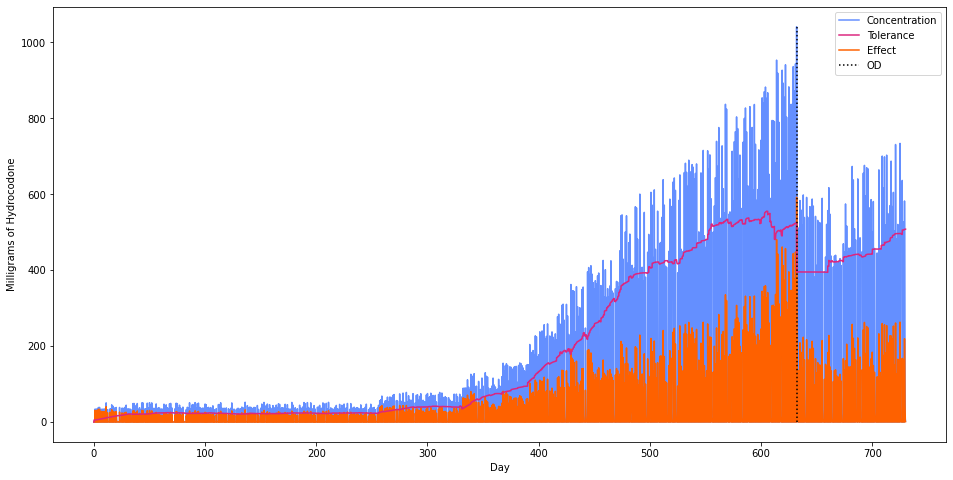

In [10]:
fig = visualize(
            simulation.person,
            show_desperation=False,
            show_habit=True,
            show_effect=True,
        )
        

In [ ]:
n_sims = 100
for i in range(n_sims):
    person = Person(rng=Random(1),)

    simulation = Simulation(person=person, rng=Random())
    simulation.simulate()

In [ ]:
pd.DataFrame(person.dose_increase_record).transpose()['success'].unique()

In [ ]:
x = {'source': 'primary_doctor', 'success': False}
x['source']

In [ ]:
#person = Person(rng=Random(1),)
person.last_dose_increase
person.took_dose

In [ ]:
simulation.availability